In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 4.3MB 39.9MB/s 
     |████████████████████████████████| 501kB 35.2MB/s 


In [2]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 516.9MB 30kB/s 
     |████████████████████████████████| 2.9MB 44.9MB/s 
     |████████████████████████████████| 2.8MB 33.9MB/s 
     |████████████████████████████████| 778kB 43.8MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 2.0.0rc1 has requirement tb-nightly<1.15.0a20190807,>=1.15.0a20190806, but you'll have tb-nightly 2.2.0a20200307 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: tb-nightly 1.15.0a20190806
    Uninstalling tb-nightly-1.15.0a20190806:
      Successfully uninstalled tb-nightly-1.15.0a20190806


In [3]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import math
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-dev20200307


In [0]:
PATH = '/content/gdrive/My Drive/dataset/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dog')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')  # directory with our validation dog pictures
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test = num_cats_test + num_dogs_test

In [0]:
def plot_value_array(i, data, title):
  plt.ylabel('num of image')
  plt.title("{}_data".format(title))
  plt.bar(range(len(data)), data)

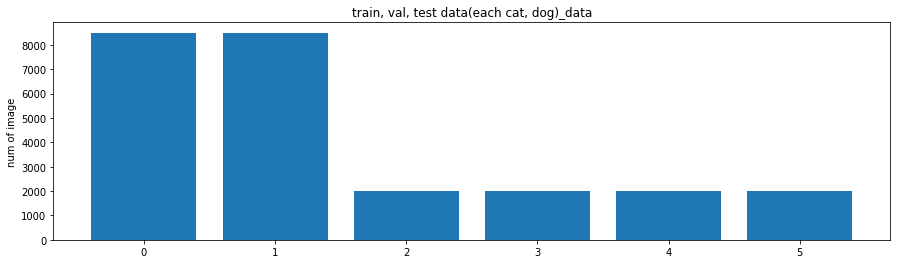

In [9]:
datas = [num_cats_tr, num_dogs_tr, num_cats_val, num_dogs_val, num_cats_test, num_dogs_test]

plt.figure(figsize=(15, 4))
plot_value_array(1, datas,'train, val, test data(each cat, dog)')

In [10]:
#tensorflow loader

batch_size = 20
epochs = 100
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=40,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [0]:
#음수의 값을 표현하기 위함.
def swish_activation(x):
  return x * tf.nn.sigmoid(x)

In [0]:
class EfficientNet_classification(tf.keras.layers.Layer):
  def __init__(self, pooling='avg', classes=1):
    super(EfficientNet_classification, self).__init__()
    self.classes = classes
    self.pooling = pooling

    self.avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.max_pooling = tf.keras.layers.GlobalMaxPooling2D()

    self.sigmoid_fc = tf.keras.layers.Dense(units=classes, activation=tf.keras.activations.sigmoid)
    self.softmax_fc = tf.keras.layers.Dense(units=classes, activation=tf.keras.activations.softmax)


  def call(self, inputs):
    if self.pooling == 'avg':
      x = self.avg_pooling(inputs)
    elif self.pooling == 'max':
      x = self.max_pooling(inputs)

    if self.classes == 1:
      x = self.sigmoid_fc(x)
    else:
      x = self.softmax_fc(x)
      
    return x

In [0]:
class MBConv_Block(tf.keras.layers.Layer):
  def __init__(self, block_arg):
    super(MBConv_Block, self).__init__()

    self.kernel_size = block_arg['kernel_size']
    self.num_repeat= block_arg['num_repeat']
    self.input_filters= block_arg['input_filters']
    self.output_filters= block_arg['kernel_size']
    self.expand_ratio= block_arg['expand_ratio']
    self.id_skip= block_arg['id_skip']
    self.strides= block_arg['strides']
    self.se_ratio= block_arg['se_ratio']

    # expansion phase
    self.expanded_filters =  self.input_filters * self.expand_ratio
    self.conv_1 = tf.keras.layers.Conv2D(filters = self.expanded_filters, 
                                          kernel_size=(1, 1),  
                                          padding='same',  
                                          use_bias=False)
    self.bn_1 = tf.keras.layers.BatchNormalization()

    # Depthwise convolution phase
    self.dw_conv_1 = tf.keras.layers.DepthwiseConv2D(kernel_size = self.kernel_size, 
                                                     strides = self.strides,  
                                                     padding='same',  
                                                     use_bias=False)
    self.bn_2 = tf.keras.layers.BatchNormalization()

    # Squeeze and excitation phase
    self.se_1 = tf.keras.layers.GlobalAveragePooling2D()
    self.se_2 = tf.keras.layers.Reshape((1, 1, self.expanded_filters ))
    self.squeezed_filters = max (1, int(self.input_filters * self.se_ratio))

    # activation 뒤로 뺌. (call에서 처리 필요. - 둘 다, swish, sigmoid) 
    self.se_3 = tf.keras.layers.Conv2D(filters = self.squeezed_filters, 
                                       kernel_size=(1, 1), 
                                       padding='same')
    self.se_4 = tf.keras.layers.Conv2D(filters = self.expanded_filters, 
                                       kernel_size=(1, 1), 
                                       padding='same')
    # Output phase
    self.conv_2 = tf.keras.layers.Conv2D(filters = self.output_filters, 
                                         kernel_size=(1, 1), 
                                         padding='same', 
                                         use_bias=False)
    self.bn_3 = tf.keras.layers.BatchNormalization()

  def call(self, inputs):
    # expansion phase
    x = self.conv_1(inputs)
    x = self.bn_1(x)
    x = swish_activation(x)
    # Depthwise convolution phase
    x = self.dw_conv_1(x)
    x = self.bn_2(x)
    x = swish_activation(x)
    # Squeeze and excitation phase
    se = self.se_1(x)
    se = self.se_2(x)
    se = self.se_3(x)
    se = swish_activation(x)
    se = self.se_4(x)
    se = tf.nn.sigmoid(x)
    x = tf.keras.layers.multiply([x, se])
    # Output phase
    x = self.conv_2(x)
    x = self.bn_3(x)
    
    return x

In [0]:
class EfficientNet(tf.keras.Model):
  def __init__(self, argument_block=None, pool='avg', classes=1000, include_top=True):
    super(EfficientNet, self).__init__()
    self.conv_1 = tf.keras.layers.Conv2D(filters=32,
                                         kernel_size=(3, 3),
                                         strides=2,
                                         padding="same")
    self.bn_1 = tf.keras.layers.BatchNormalization()

    self.efficientnet_1 = MBConv_Block(argument_block['BlockArgs_1'])
    self.efficientnet_2 = MBConv_Block(argument_block['BlockArgs_2'])
    self.efficientnet_3 = MBConv_Block(argument_block['BlockArgs_3'])
    self.efficientnet_4 = MBConv_Block(argument_block['BlockArgs_4'])
    self.efficientnet_5 = MBConv_Block(argument_block['BlockArgs_5'])
    self.efficientnet_6 = MBConv_Block(argument_block['BlockArgs_6'])
    self.efficientnet_7 = MBConv_Block(argument_block['BlockArgs_7'])

    self.conv_2 = tf.keras.layers.Conv2D(filters=1280,
                                        kernel_size=(1, 1),
                                        strides=1,
                                        padding="same")
    self.bn_2 = tf.keras.layers.BatchNormalization()
    self.fc = EfficientNet_classification(pooling=pool, classes=classes)
  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.bn_1(x)
    x = self.efficientnet_1(x)
    x = self.efficientnet_2(x)
    x = self.efficientnet_3(x)
    x = self.efficientnet_4(x)
    x = self.efficientnet_5(x)
    x = self.efficientnet_6(x)
    x = self.efficientnet_7(x)
    x = self.conv_2(x)
    x = self.bn_2(x)
    x = self.fc(x)

    return x

kernel_size는 컨볼 루션의 커널 크기입니다. 예 : 3 x 3

num_repeat는 특정 블록을 몇 번 반복해야하는지 지정합니다. 0보다 커야합니다.

input_filters 및 output_filters는 지정된 필터 수입니다.

expand_ratio는 입력 필터 확장 비율입니다.

id_skip는 건너 뛰기 연결 사용 여부를 제안합니다

se_ratio는 압착 및 여기 블록에 대한 압착 비율을 제공합니다

In [0]:
#EfficientNetB0 블럭 하이퍼파라미터.
def efficient_B0():
  argument_block= {
      'BlockArgs_1':{'kernel_size':3, 'num_repeat':1, 'input_filters':32, 'output_filters':16, 'expand_ratio':1, 'id_skip':True, 'strides':[1, 1], 'se_ratio':0.25},
      'BlockArgs_2':{'kernel_size':3, 'num_repeat':2, 'input_filters':16, 'output_filters':24, 'expand_ratio':6, 'id_skip':True, 'strides':[2, 2], 'se_ratio':0.25},
      'BlockArgs_3':{'kernel_size':5, 'num_repeat':2, 'input_filters':24, 'output_filters':40, 'expand_ratio':6, 'id_skip':True, 'strides':[2, 2], 'se_ratio':0.25},
      'BlockArgs_4':{'kernel_size':3, 'num_repeat':3, 'input_filters':40, 'output_filters':80, 'expand_ratio':6, 'id_skip':True, 'strides':[2, 2], 'se_ratio':0.25},
      'BlockArgs_5':{'kernel_size':5, 'num_repeat':3, 'input_filters':80, 'output_filters':112, 'expand_ratio':6, 'id_skip':True, 'strides':[1, 1], 'se_ratio':0.25},
      'BlockArgs_6':{'kernel_size':5, 'num_repeat':4, 'input_filters':112, 'output_filters':192, 'expand_ratio':6, 'id_skip':True, 'strides':[2, 2], 'se_ratio':0.25},
      'BlockArgs_7':{'kernel_size':3, 'num_repeat':1, 'input_filters':192, 'output_filters':320, 'expand_ratio':6, 'id_skip':True, 'strides':[1, 1], 'se_ratio':0.25}
  }

  return EfficientNet(argument_block=argument_block, pool='avg', classes=1, include_top=True)

In [0]:
efficient_b0 = efficient_B0()

In [210]:
def print_model_summary(network):
    network.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))
    network.summary()

print_model_summary(network=efficient_b0)

Model: "efficient_net_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1049 (Conv2D)         multiple                  896       
_________________________________________________________________
batch_normalization_802 (Bat multiple                  128       
_________________________________________________________________
mb_conv__block_185 (MBConv_B multiple                  2996      
_________________________________________________________________
mb_conv__block_186 (MBConv_B multiple                  11920     
_________________________________________________________________
mb_conv__block_187 (MBConv_B multiple                  27674     
_________________________________________________________________
mb_conv__block_188 (MBConv_B multiple                  66262     
_________________________________________________________________
mb_conv__block_189 (MBConv_B multiple             

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

efficient_b0.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = efficient_b0.fit_generator(
    train_data_gen,
    steps_per_epoch = 80,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = 20
)

Epoch 1/100
80/80 [==============================] - 610s 8s/step - loss: 0.7048 - accuracy: 0.5113 - val_loss: 0.6941 - val_accuracy: 0.4500
Epoch 2/100
80/80 [==============================] - 597s 7s/step - loss: 0.6860 - accuracy: 0.5606 - val_loss: 0.6940 - val_accuracy: 0.4625
Epoch 3/100
80/80 [==============================] - 609s 8s/step - loss: 0.6738 - accuracy: 0.5750 - val_loss: 0.6913 - val_accuracy: 0.5375
Epoch 4/100
80/80 [==============================] - 586s 7s/step - loss: 0.6813 - accuracy: 0.5669 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 5/100
80/80 [==============================] - 587s 7s/step - loss: 0.6748 - accuracy: 0.5569 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 6/100
80/80 [==============================] - 587s 7s/step - loss: 0.6516 - accuracy: 0.6137 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
80/80 [==============================] - 596s 7s/step - loss: 0.6535 - accuracy: 0.6069 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 

In [0]:
# define loss and optimizer
    loss_object = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

    valid_loss = tf.keras.metrics.Mean(name='valid_loss')
    valid_accuracy = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')

    # @tf.function
    def train_step(image_batch, label_batch):
        with tf.GradientTape() as tape:
            predictions = vgg16(image_batch, training=True)
            loss = loss_object(y_true=label_batch, y_pred=predictions)
        gradients = tape.gradient(loss, vgg16.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, vgg16.trainable_variables))

        train_loss.update_state(values=loss)
        train_accuracy.update_state(y_true=label_batch, y_pred=predictions)

    # @tf.function
    def valid_step(image_batch, label_batch):
        predictions = vgg16(image_batch, training=False)
        v_loss = loss_object(label_batch, predictions)

        valid_loss.update_state(values=v_loss)
        valid_accuracy.update_state(y_true=label_batch, y_pred=predictions)

    # start training
    for epoch in range(epochs):
        step = 0
        for features in train_data_gen:
            step += 1
            images, labels = features
            train_step(images, labels)
            print('.', end='')
                # print("Epoch: {}/{}, step: {}/{}, loss: {:.5f}, accuracy: {:.5f}".format(epoch + 1,
                #                                                                         epochs,
                #                                                                         step,
                #                                                                          #현재 augmentation부분을 고려하지 않고 계산되는 부분 개선 필요.
                #                                                                         math.ceil(total_train / batch_size),
                #                                                                         train_loss.result().numpy(),
                #                                                                         train_accuracy.result().numpy()))

        for features in val_data_gen:
            valid_images, valid_labels = features
            valid_step(valid_images, valid_labels)
        print('\n')
        print("Epoch: {}/{}, train loss: {:.5f}, train accuracy: {:.5f}, "
              "valid loss: {:.5f}, valid accuracy: {:.5f}".format(epoch + 1,
                                                                  epochs,
                                                                  train_loss.result().numpy(),
                                                                  train_accuracy.result().numpy(),
                                                                  valid_loss.result().numpy(),
                                                                  valid_accuracy.result().numpy()))
        train_loss.reset_states()
        train_accuracy.reset_states()
        valid_loss.reset_states()
        valid_accuracy.reset_states()

        if (epoch + 1) % save_every_n_epoch == 0:
            model.save_weights(filepath=save_model_dir+"epoch-{}".format(epoch), save_format='tf')


    # save weights
    model.save_weights(filepath=save_model_dir+"model", save_format='tf')

    # save the whole model
    # tf.saved_model.save(model, save_model_dir)

    # convert to tensorflow lite format
    # model._set_inputs(inputs=tf.random.normal(shape=(1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
    # converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # tflite_model = converter.convert()
    # open("converted_model.tflite", "wb").write(tflite_model)

In [0]:
#https://heartbeat.fritz.ai/reviewing-efficientnet-increasing-the-accuracy-and-robustness-of-cnns-6aaf411fc81d - EfficientNet 모델 사이트 굳굳!
#https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6 -여기도 굳굳!!